In [104]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re

import faiss
from gensim.models.fasttext import FastText
from gensim.models.callbacks import CallbackAny2Vec

import torch
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [6]:
TRAIN_RATIO = 0.8
TRAIN_SPLIT_SEED = 0

In [7]:
ref = pd.read_csv('clean_ref.csv')
pairs = pd.read_csv('clean_train.csv')

TRAIN_RATIO = 0.8
TRAIN_SPLIT_SEED = 0

np.random.seed(TRAIN_SPLIT_SEED)
train = np.random.rand(pairs.shape[0]) < TRAIN_RATIO
pairs_train = pairs[train]
pairs_test = pairs[~train]

In [8]:
# https://github.com/gorodion/Goods-Classifier/blob/master/summary.ipynb

def normalize(ser: pd.Series):
#   "СокДобрый" -> "Сок Добрый"
    camel_case_pat = re.compile(r'([а-яa-z])([А-ЯA-Z])')
# #   "lmno" -> "лмно"
#     trans_table = make_trans()
# #   "14х15х30" -> "DxDxD"
#     dxdxd_pat = re.compile(r'((?:\d+\s*[х\*]\s*){2}\d+)')
#   "1.2 15,5" -> "1p2 15p5"  
    digit_pat = re.compile(r'(\d+)[\.,](\d+)')
#   "15 мл" -> "15мл"
    unit = 'мг|г|гр|кг|мл|л|шт'
    unit_pat = re.compile(fr'((?:\d+p)?\d+)\s*({unit})\b')
# #   "ж/б ст/б" -> "жб стб"
#     w_w_pat = re.compile(r'\b([а-я]{1,2})/([а-я]{1,2})\b')
# #   "a b c d" -> "abcd"
#     glue_pat = re.compile(r'(?<=(?<!\w)\w) (?=\w(?!\w))', re.UNICODE)
    
    return ser \
            .str.replace(camel_case_pat, r'\1 \2', regex=True) \
            .str.lower() \
            .str.replace(r'ъ\b', '', regex=True) \
            .str.replace('№', ' NUM ') \
            .str.replace('%', ' PERC ') \
            .str.replace(digit_pat, r' \1p\2 ', regex=True) \
            .str.replace(unit_pat, r' \1\2 ', regex=True) \
            .str.replace(r'[\W_]', ' ', regex=True)

In [11]:
ref['norm_desc'] = normalize(ref['description'])

for df in [pairs_train, pairs_test]:
    df['norm_desc'] = normalize(df['description'])
    df['norm_supp'] = normalize(df['supplier_name'])

<ipython-input-11-98dd118bd246>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_desc'] = normalize(df['description'])
<ipython-input-11-98dd118bd246>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['norm_supp'] = normalize(df['supplier_name'])
<ipython-input-11-98dd118bd246>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,code,description,supplier_name
0,065.8000.3296,"Телевизор LED LG 43US662H Direct LED 43""",Телевизор 43US662H
1,065.8000.3297,"Телевизор LED LG 50US662H 50""",Телевизор 50US662H
2,066.5602.2128,"Коммутатор управляемый Eltex MES2348B RS-232, ...","MES2348B_AC Ethernet-коммутатор MES2348B, 48 п..."
3,035.7800.H271,Кабель прямого соединения активный 1м SFP+ - S...,"FH-DP1T30SS01 SFP+ Direct attach cable, 10G, 1m"
4,066.5602.2127,"Коммутатор управляемый Eltex MES2324B RS-232, ...","MES2324B_AC Ethernet-коммутатор MES2324B, 24 п..."
...,...,...,...
42096,045.9000.G183,"Замок (автотранспорт) двери передней, правый A...",ЗАМОК ДВЕРИ ПРАВЫЙ ОАО ГАЗ А21R23.6105012
42097,045.9000.G149,Защелка 2705.8213109 автомобиль ГАЗ,ЗАЩЕЛКА ЗАМКА ПР ОАО ГАЗ 2705.8213109
42098,045.9000.G160,Защелка 2705-8213110 автомобиль ГАЗ,ЗАЩЕЛКА ЗАМКА ЛЕВ ОАО ГАЗ 2705.8213110
42099,045.9000.G184,"Замок (автотранспорт) двери передней, правый A...",ЗАМОК ДВЕРИ ЛЕВЫЙ ОАО ГАЗ А21R23.6105013


In [14]:
# class MyCallback(CallbackAny2Vec):
#     '''Callback to print loss after each epoch.'''

#     def __init__(self):
#         self.epoch = 0

#     def on_epoch_end(self, model):
#         loss = model.get_latest_training_loss()
#         print('Loss after epoch {}: {}'.format(self.epoch, loss))
#         self.epoch += 1
        
model = FastText(
    ref['norm_desc'].apply(lambda x: [w for w in x.split(' ') if len(w) > 0]),
    vector_size=128,
    window=5,
    workers=12,
    epochs=25,
    sg=1,
    bucket=400_000,
#     callbacks=[MyCallback()]
)

In [63]:
model.save('2_fasttext/ft_128_25e.model')

In [44]:
rnn = torch.nn.LSTM(input_size=128, hidden_size=128, num_layers=3, bidirectional=True)

In [45]:
pairs_train['norm_supp'].values[10]

'кабель hdmi premium high speed не менее  2p0   не менее  1p5 м  '

In [21]:
sent = ['кабель hdmi premium high speed не менее  2p0   не менее  1p5 м  ']

In [26]:
def get_embeddings(wv, sent):
    words = [x for x in sent.split(' ') if len(x) > 0]
    return np.vstack([wv[word] for word in words])

In [29]:
emb = get_embeddings(model.wv, sent[0])

In [85]:


class PhrasesDataset(Dataset):
    def __init__(self, train_df, wv_model):
        self.queries = train_df['norm_supp'].values
        self.true_ans = train_df['norm_desc'].values
        self.wv_model = wv_model

    def __len__(self):
        return len(self.true_ans)

    def __getitem__(self, idx):
        query = get_embeddings(self.wv_model, self.queries[idx])
        true_ans = get_embeddings(self.wv_model, self.true_ans[idx])
        false_idx = np.random.randint(0, len(self.true_ans))

        false_ans = get_embeddings(self.wv_model, self.true_ans[false_idx])

        return torch.tensor(query), torch.tensor(true_ans), torch.tensor(false_ans)

torch.Size([20, 16, 128])

In [231]:


def my_collator(x):
    l = len(x[0])
    return [pad_sequence([x_[i] for x_ in x]) for i in range(l)]

ds = PhrasesDataset(pairs_train, model.wv)
training_loader = DataLoader(ds, batch_size=BATCH_SIZE, collate_fn=my_collator)
loss_fn = torch.nn.CosineEmbeddingLoss(reduction='sum')

optimizer = Adam(rnn.parameters(), lr=0.0001)

def train_one_epoch(rnn, training_loader, optimizer, loss_fn):
    losses = []
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        qs, ta, fa = data

        optimizer.zero_grad()

        # Make predictions for this batch
        q_emb = rnn(qs)[1][0][-1, :, :]
        t_emb = rnn(ta)[1][0][-1, :, :]
        f_emb = rnn(fa)[1][0][-1, :, :]
        
        
        
        # Compute the loss and its gradients
        loss_pos = loss_fn(q_emb, t_emb, torch.ones(q_emb.shape[0]))
        loss_neg = loss_fn(q_emb, f_emb, (-1) * torch.ones(q_emb.shape[0]))
        
        loss = loss_pos + 2*loss_neg
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        losses.append((loss_pos.item(), loss_neg.item()))
        if i % 100 == 99:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss_pos: {} loss_neg: {}'.format(i + 1, loss_pos.item(), loss_neg.item()))
            running_loss = 0.

    return losses

  batch 100 loss_pos: 44.42448043823242 loss_neg: 16.119279861450195
  batch 200 loss_pos: 37.784156799316406 loss_neg: 12.260708808898926
  batch 100 loss_pos: 28.851882934570312 loss_neg: 10.854279518127441
  batch 200 loss_pos: 26.53734016418457 loss_neg: 12.022826194763184
  batch 100 loss_pos: 20.819408416748047 loss_neg: 11.09994888305664
  batch 200 loss_pos: 20.098783493041992 loss_neg: 11.918848037719727
  batch 100 loss_pos: 17.531280517578125 loss_neg: 11.480088233947754
  batch 200 loss_pos: 16.34326934814453 loss_neg: 14.255736351013184
  batch 100 loss_pos: 14.343218803405762 loss_neg: 12.90694522857666
  batch 200 loss_pos: 16.822023391723633 loss_neg: 9.847038269042969
  batch 100 loss_pos: 12.99965763092041 loss_neg: 10.895750999450684
  batch 200 loss_pos: 12.05395793914795 loss_neg: 7.393333435058594
  batch 100 loss_pos: 12.240486145019531 loss_neg: 11.263832092285156
  batch 200 loss_pos: 14.927499771118164 loss_neg: 12.416749954223633
  batch 100 loss_pos: 13.3617

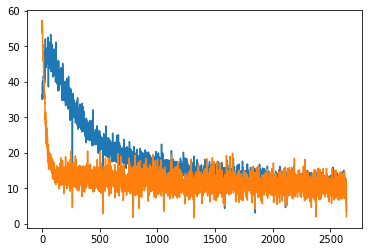

In [237]:
EPOCHS = 10
BATCH_SIZE = 128

rnn = torch.nn.LSTM(input_size=128, hidden_size=64, num_layers=1, bidirectional=True)
ds = PhrasesDataset(pairs_train, model.wv)
training_loader = DataLoader(ds, batch_size=BATCH_SIZE, collate_fn=my_collator, shuffle=True)
loss_fn = torch.nn.CosineEmbeddingLoss(reduction='sum')

optimizer = Adam(rnn.parameters(), lr=0.0001)


losses = []
for e in range(EPOCHS):
    l = train_one_epoch(rnn, training_loader, optimizer, loss_fn)
    losses.extend(l)
    
plt.plot(losses)

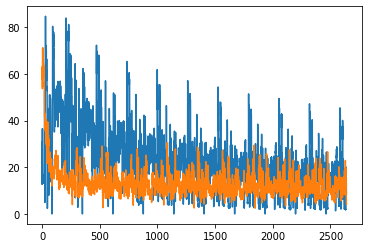

In [233]:
plt.plot([x[0] for x in losses])
plt.plot([x[1] for x in losses])

In [239]:
class RefDataset(Dataset):
    def __init__(self, train_df, cols, wv_model):
        self.cols = cols
        self.cols_vals = {}
        for c in cols:
            self.cols_vals[c] = train_df[c].values
        self.wv_model = wv_model

    def __len__(self):
        some_col = self.cols[0]
#         print(self.cols_vals)
        col_vals = self.cols_vals[some_col]
        return len(col_vals)

    def __getitem__(self, idx):
        ret = []
        for c in self.cols:
            ret.append(get_embeddings(self.wv_model, self.cols_vals[c][idx]))
        return [torch.tensor(x) for x in ret]

ref_ds = RefDataset(ref, ['norm_desc'], model.wv)
ref_dl = DataLoader(ref_ds, batch_size=1024, collate_fn=my_collator)

test_ds = RefDataset(pairs_test, ['norm_supp'], model.wv)
test_dl = DataLoader(test_ds, batch_size=1024, collate_fn=my_collator)

In [253]:
o = next(iter(ref_dl))

In [254]:
rnn_out = rnn(o[0])

In [259]:
rnn_out[1][1].shape

torch.Size([2, 1024, 64])

In [252]:
o[0, 100, :]

tensor([ 0.0685,  0.0214, -0.0079, -0.0259, -0.0182, -0.0642,  0.0314,  0.0711,
        -0.0039,  0.0032,  0.0149,  0.0551, -0.0167, -0.0044,  0.0451,  0.0569,
        -0.0172,  0.0626,  0.0169, -0.0029, -0.0061,  0.0103, -0.0541, -0.0325,
         0.0242, -0.1169,  0.0223, -0.0378, -0.0019, -0.0830,  0.0421,  0.0957,
        -0.0190, -0.0304,  0.0238, -0.0318,  0.0581, -0.0089,  0.0191, -0.0563,
        -0.0060,  0.0218, -0.0906, -0.1022, -0.0463,  0.0038,  0.0319,  0.0809,
        -0.0762,  0.0226, -0.0919,  0.0108, -0.0063, -0.0318, -0.0086,  0.0952,
         0.0300,  0.0124, -0.0171, -0.0177,  0.0650,  0.0163, -0.0285,  0.0855],
       grad_fn=<SliceBackward>)

In [212]:
ref_embs = []
for i, data in enumerate(ref_dl):
    e = rnn(data[0])[0][-1, :, :].detach().numpy()
    ref_embs.append(e)
ref_embs = np.vstack(ref_embs)

test_embs = []
for i, data in enumerate(test_dl):
    e = rnn(data[0])[0][-1, :, :].detach().numpy()
    test_embs.append(e)
test_embs = np.vstack(test_embs)



index = faiss.IndexFlatIP(128)
faiss.normalize_L2(ref_embs)
index.add(ref_embs)
print(index.ntotal)


N = 10

faiss.normalize_L2(test_embs)
dist, ids = index.search(test_embs, N)

pairs_test[[f'best_{i}_dist' for i in range(N)]] = dist
pairs_test[[f'best_{i}_item' for i in range(N)]] = ids

293569


(293569, 128)

ValueError: not enough values to unpack (expected 2, got 1)

In [218]:
ref['index'] = ref.index
pairs_test = pairs_test \
            .merge(ref[['index', 'description']], on='description') \
            .rename(columns={'index': 'reference_index'})

In [217]:
# pairs_test = pairs_test.drop('reference_index', axis=1)

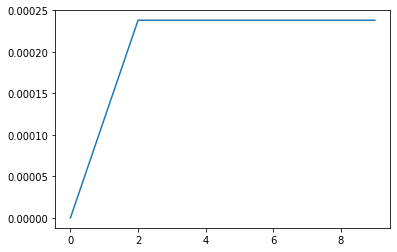

In [219]:
coinside = pairs_test['best_0_item'] == pairs_test['reference_index']
res = [coinside.mean()]
for i in range(1, 10):
    coinside = coinside | (pairs_test[f'best_{i}_item'] == pairs_test['reference_index'])
    res.append(coinside.mean())
    
plt.plot(res)

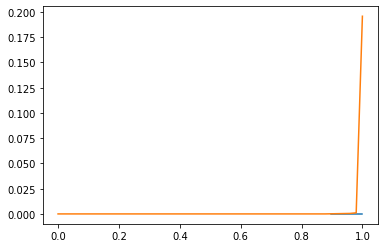

In [222]:
confs = np.linspace(0, 1)
acc = np.zeros_like(confs)
rec = np.zeros_like(confs)

for i, x in enumerate(confs):
    conf_enough = pairs_test['best_0_dist'] < x
    rec[i] = conf_enough.mean()
    acc[i] = (pairs_test['best_0_item'] == pairs_test['reference_index'])[conf_enough].mean()
    
plt.plot(confs, acc)
plt.plot(confs, rec)

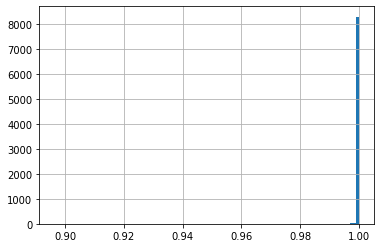

In [221]:
pairs_test['best_0_dist'].hist(bins=100)